In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os, random
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/image")
DATASET_DIR = BASE_DIR / "dataset60"
assert DATASET_DIR.exists(), f"dataset60 경로 없음: {DATASET_DIR}"

print("DATASET_DIR =", DATASET_DIR)

Mounted at /content/drive
DATASET_DIR = /content/drive/MyDrive/image/dataset60


In [2]:
# 레포 클론
%cd /content
!rm -rf watermark-anything
!git clone https://github.com/facebookresearch/watermark-anything.git

%cd /content/watermark-anything

# 의존성 설치(필요한 것만 + 품질지표용)
!pip -q install -r requirements.txt
!pip -q install scikit-image matplotlib

# 체크포인트 폴더 준비
!mkdir -p checkpoints

# MIT 가중치 다운로드
!wget -q https://dl.fbaipublicfiles.com/watermark_anything/wam_mit.pth -O checkpoints/checkpoint.pth

print("Done.")

/content
Cloning into 'watermark-anything'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 168 (delta 48), reused 39 (delta 39), pack-reused 116 (from 1)
Receiving objects: 100% (168/168), 7.04 MiB | 22.67 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/watermark-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 1

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

from watermark_anything.data.metrics import msg_predict_inference
from notebooks.inference_utils import (
    load_model_from_checkpoint,
    default_transform,
    unnormalize_img,
    create_random_mask,
    msg2str
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

# params.json은 레포의 checkpoints/params.json 경로를 사용
json_path = "/content/watermark-anything/checkpoints/params.json"
ckpt_path = "/content/watermark-anything/checkpoints/checkpoint.pth"

assert os.path.exists(json_path), f"params.json 없음: {json_path}"
assert os.path.exists(ckpt_path), f"checkpoint.pth 없음: {ckpt_path}"

wam = load_model_from_checkpoint(json_path, ckpt_path).to(device).eval()
print("WAM loaded.")

device = cuda
making attention of type 'vanilla' with 64 in_channels
Working with z of shape (1, 68, 32, 32) = 69632 dimensions.
making attention of type 'vanilla' with 64 in_channels
Model loaded successfully from /content/watermark-anything/checkpoints/checkpoint.pth
{'embedder_config': 'configs/embedder.yaml', 'augmentation_config': 'configs/all_augs_multi_wm.yaml', 'extractor_config': 'configs/extractor.yaml', 'attenuation_config': 'configs/attenuation.yaml', 'embedder_model': 'vae_small', 'extractor_model': 'sam_base', 'nbits': 32, 'img_size': 256, 'img_size_extractor': 256, 'attenuation': 'jnd_1_3_blue', 'scaling_w': 2.0, 'scaling_w_schedule': None, 'scaling_i': 1.0, 'roll_probability': 0.2, 'multiple_w': 1.0, 'nb_wm_eval': 5, 'optimizer': 'AdamW,lr=1e-4', 'optimizer_d': None, 'scheduler': 'CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', 'epochs': 200, 'batch_size': 8, 'batch_size_eval': 16, 'temperature': 1.0, 'workers': 8, 'to_freeze_embedder': None

In [5]:
IMG_EXT = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}
all_paths = [p for p in DATASET_DIR.glob("*") if p.suffix.lower() in IMG_EXT]

assert len(all_paths) >= 5, f"이미지 개수 부족: {len(all_paths)}"
picked = random.sample(all_paths, 5)

print("Picked 5 images:")
for p in picked:
    print("-", p.name)

Picked 5 images:
- dt_036.png
- dt_037.png
- dt_049.png
- dt_005.png
- dt_018.png


In [6]:
def tensor_to_np01(img_t: torch.Tensor) -> np.ndarray:
    # img_t: [1,3,H,W] 또는 [3,H,W], 값 범위는 unnormalize_img 이후 [0,1] 가정
    if img_t.dim() == 4:
        img_t = img_t[0]
    img_t = img_t.detach().cpu().clamp(0, 1)
    img = img_t.permute(1,2,0).numpy()  # HWC
    return img

def calc_psnr_ssim(orig_01: np.ndarray, wm_01: np.ndarray) -> tuple[float, float]:
    # orig_01, wm_01: HWC float [0,1]
    psnr = float(PSNR(orig_01, wm_01, data_range=1.0))
    ssim = float(SSIM(orig_01, wm_01, channel_axis=2, data_range=1.0))
    return psnr, ssim

def show_triplet(orig_img: np.ndarray, wm_img: np.ndarray, mask_img: np.ndarray | None, title: str):
    # orig_img, wm_img: HWC [0,1], mask_img: HW [0,1]
    diff = np.abs(wm_img - orig_img)
    cols = 4 if mask_img is not None else 3

    plt.figure(figsize=(4.5*cols, 5))
    ax = plt.subplot(1, cols, 1)
    ax.imshow(orig_img)
    ax.set_title("ORIGINAL")
    ax.axis("off")

    ax = plt.subplot(1, cols, 2)
    ax.imshow(wm_img)
    ax.set_title("WATERMARKED")
    ax.axis("off")

    ax = plt.subplot(1, cols, 3)
    ax.imshow(diff)
    ax.set_title("ABS DIFF")
    ax.axis("off")

    if mask_img is not None:
        ax = plt.subplot(1, cols, 4)
        ax.imshow(mask_img, cmap="gray")
        ax.set_title("TARGET MASK")
        ax.axis("off")

    plt.suptitle(title, y=1.03)
    plt.tight_layout()
    plt.show()

In [ ]:
"""
	•	“어디에 추가되었는지”는 target mask(우리가 넣은 위치) + 검출 시 pred mask(모델이 찾은 위치)를 같이 보여주면 가장 명확함.
	•	기본은 “부분 삽입”으로 하고, 원하면 proportion_masked=1.0으로 전체 삽입도 가능.
"""


In [7]:
WM_SAVE_DIR = Path("/content/drive/MyDrive/image/wm_img")
WM_SAVE_DIR.mkdir(parents=True, exist_ok=True)

diff min/max/mean: 0.0 0.18028925 0.044670437


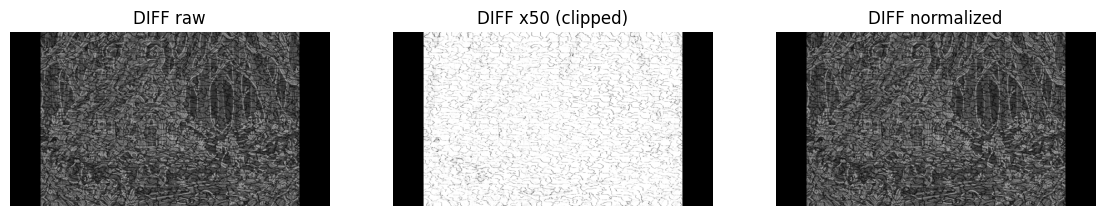

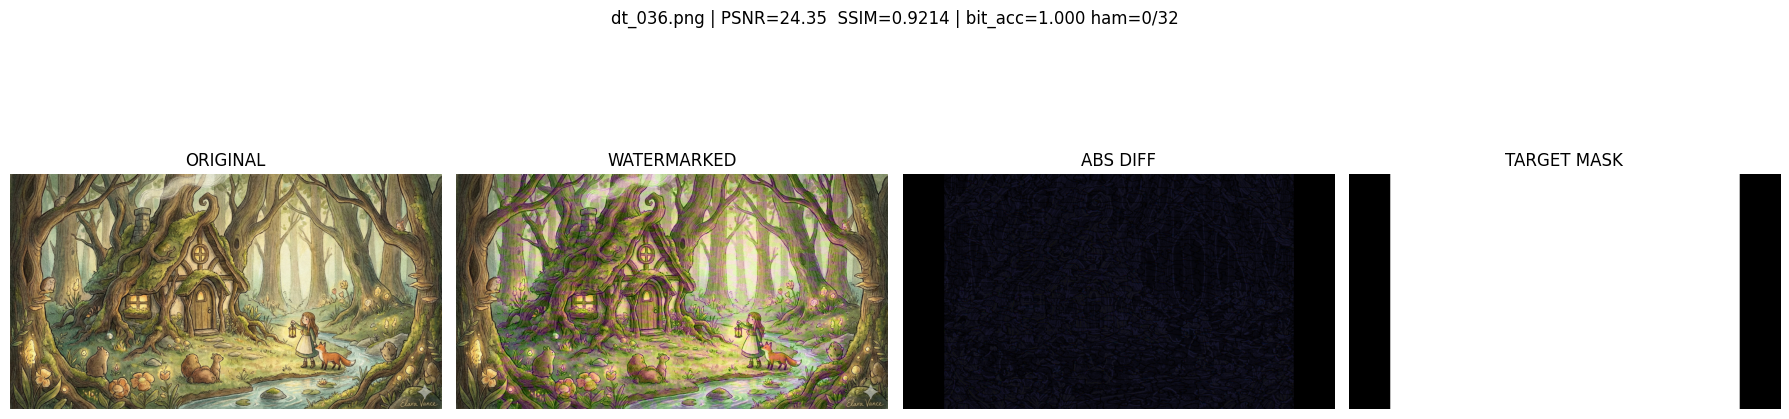

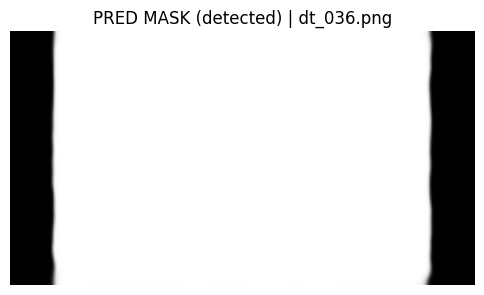

decoded msg: 10011000000011000101111100011100
gt msg     : 10011000000011000101111100011100
------------------------------------------------------------
diff min/max/mean: 0.0 0.18321522 0.036637507


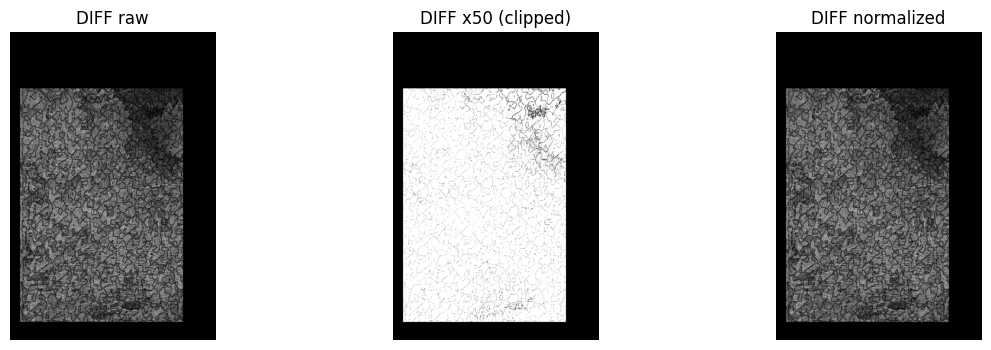

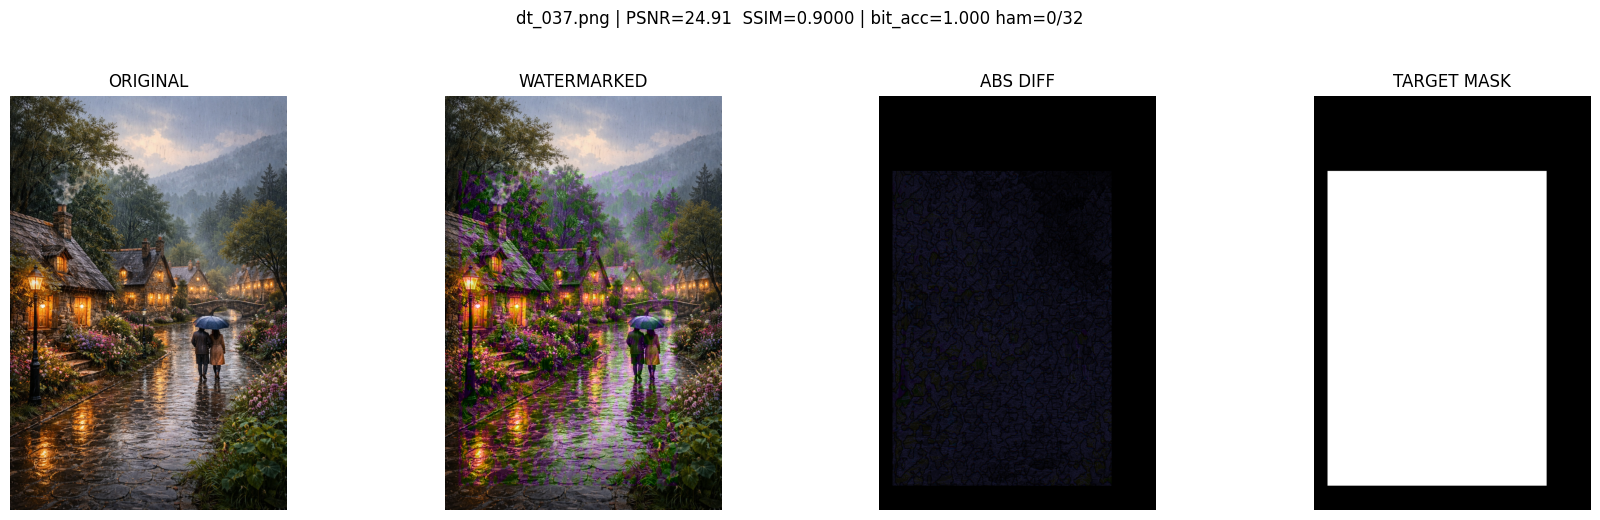

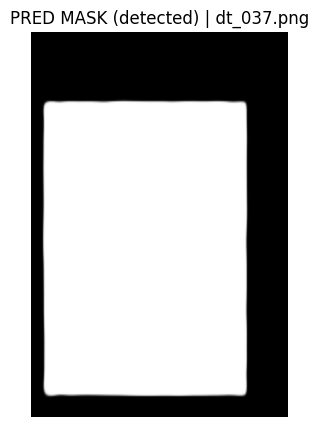

decoded msg: 01011010110111100000000111011011
gt msg     : 01011010110111100000000111011011
------------------------------------------------------------
diff min/max/mean: 0.0 0.16249585 0.011105618


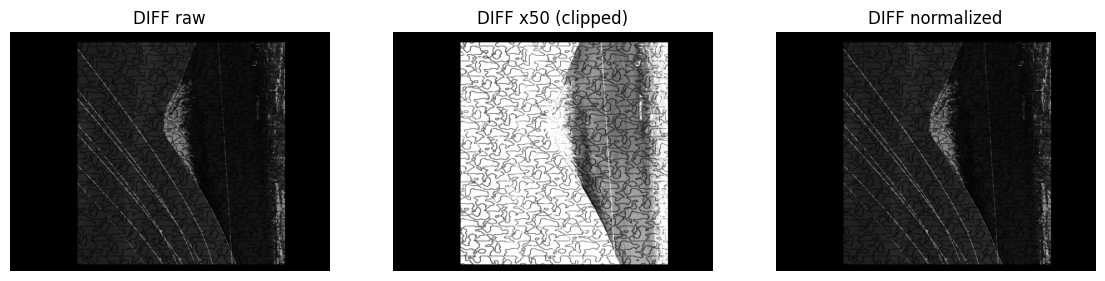

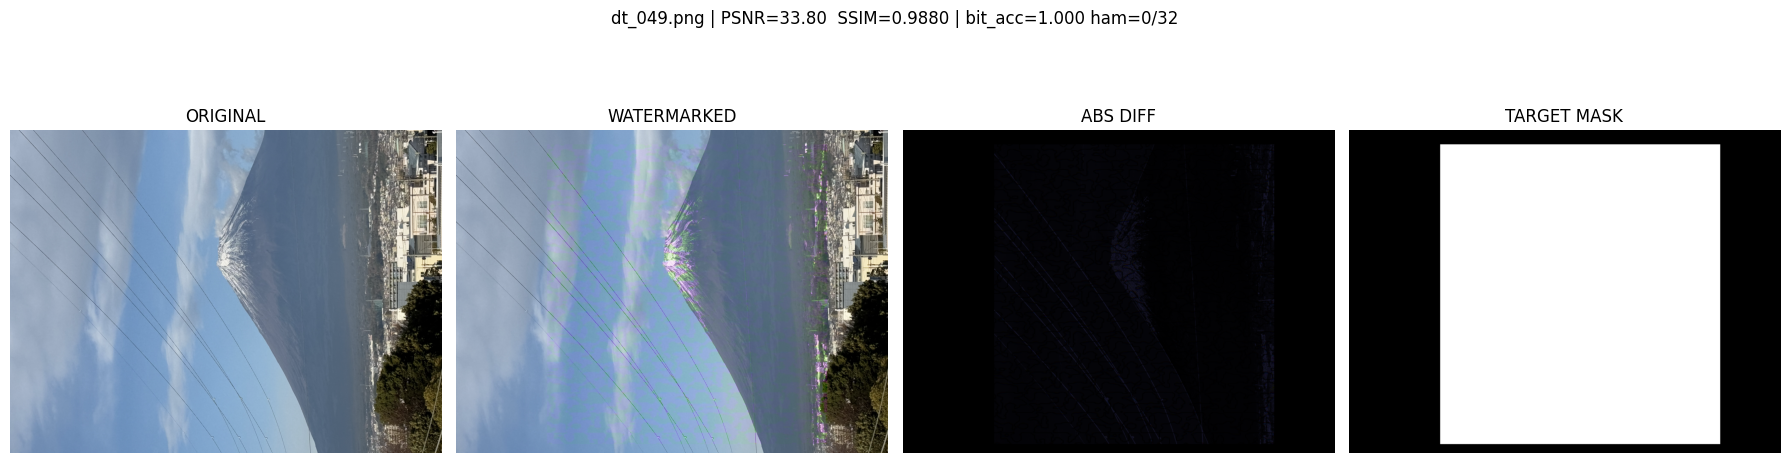

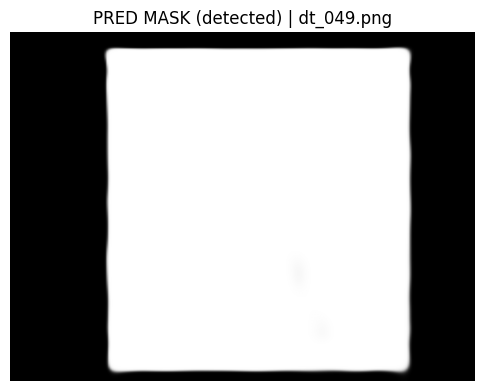

decoded msg: 10011010111101101101111000010000
gt msg     : 10011010111101101101111000010000
------------------------------------------------------------
diff min/max/mean: 0.0 0.18471237 0.032988064


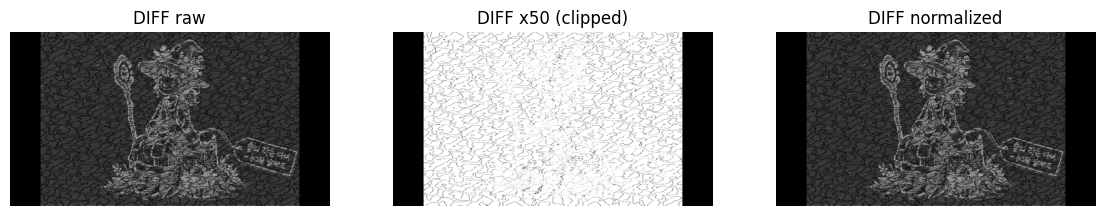

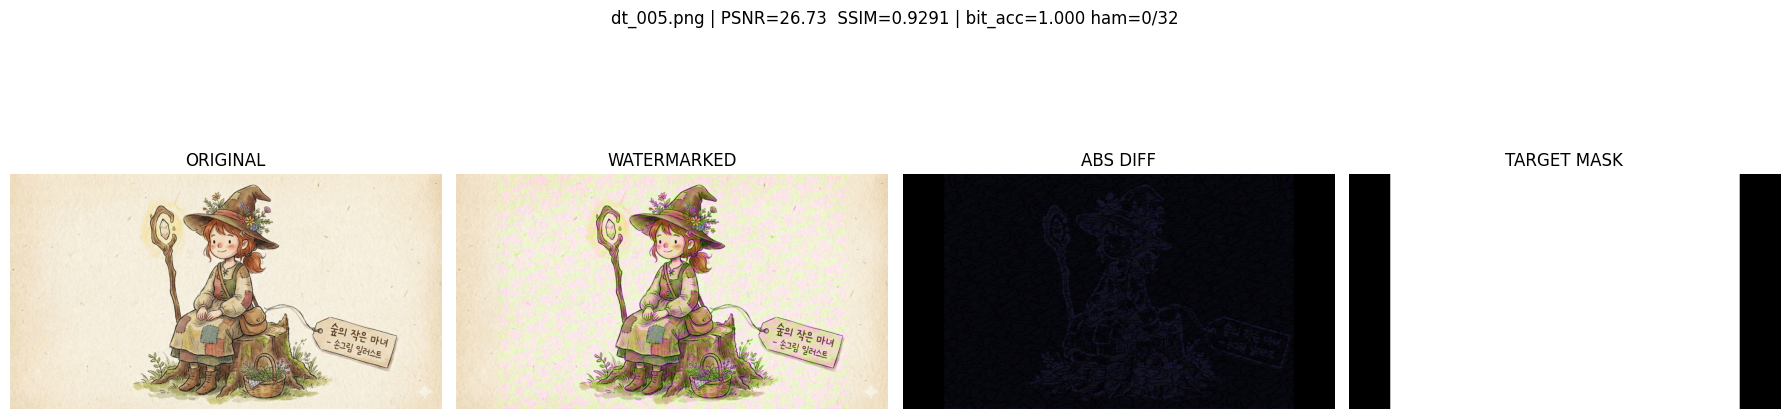

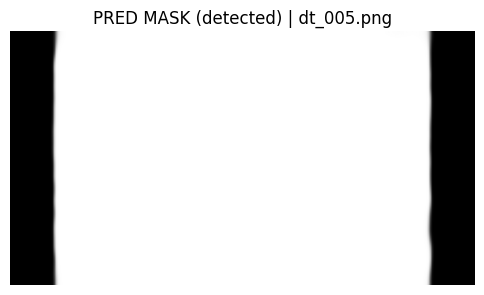

decoded msg: 11000001111010001010100010011110
gt msg     : 11000001111010001010100010011110
------------------------------------------------------------
diff min/max/mean: 0.0 0.19204502 0.022223793


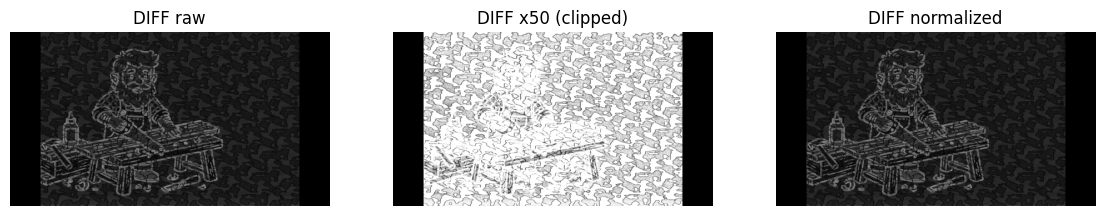

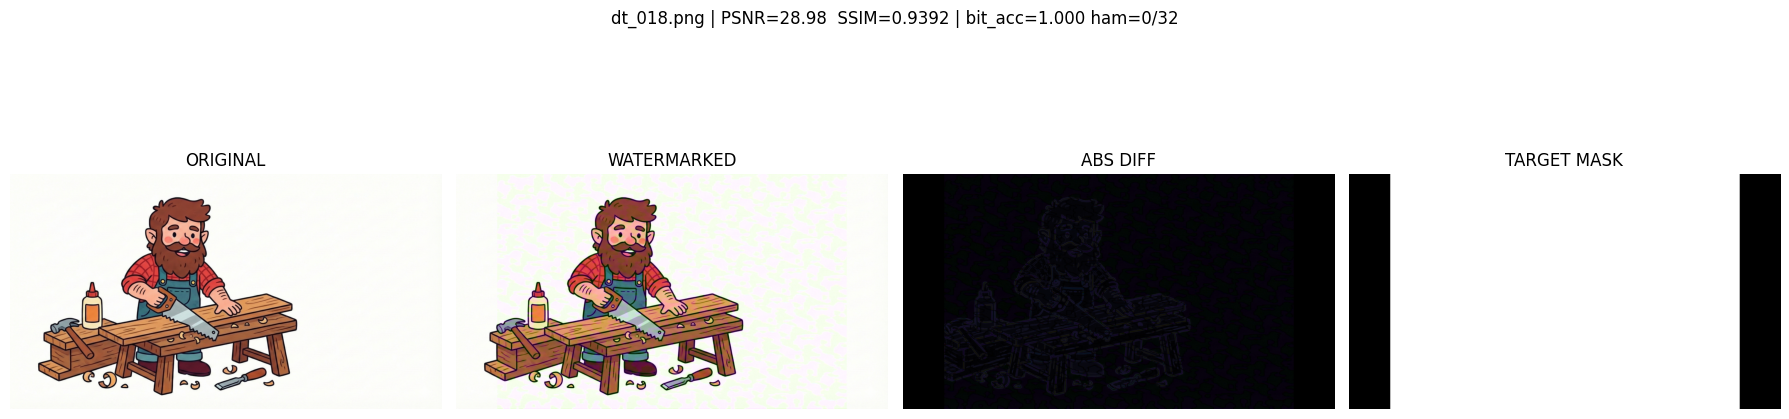

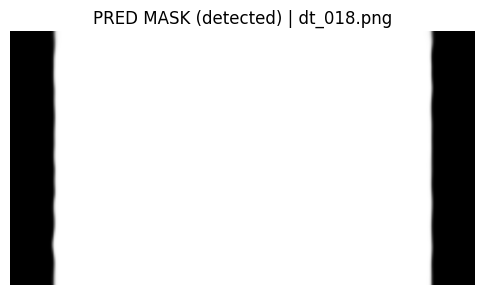

decoded msg: 10001110101011100000011111000110
gt msg     : 10001110101011100000011111000110
------------------------------------------------------------
Done.


In [8]:
proportion_masked = 0.6   # 워터마크 넣는 면적 비율(0~1)
wam.scaling_w = 10.0        # 품질/강건성 트레이드오프(기본 2.0)

results = []

for path in picked:
    # 원본 로드
    img = Image.open(path).convert("RGB")
    img_pt = default_transform(img).unsqueeze(0).to(device)  # [1,3,H,W]

    # 메시지(32bit) 생성
    wm_msg = torch.randint(0, 2, (1,32)).float().to(device)

    # 삽입(모델은 전체에 watermark 후보를 만들고)
    outputs = wam.embed(img_pt, wm_msg)
    imgs_w = outputs["imgs_w"]  # [1,3,H,W]

    # 우리가 실제로 적용할 마스크(부분 삽입)
    mask = create_random_mask(img_pt, num_masks=1, mask_percentage=proportion_masked)  # [1,1,H,W]
    img_w = imgs_w * mask + img_pt * (1 - mask)

    # 검출
    preds = wam.detect(img_w)["preds"]              # [1,33,256,256]
    mask_preds = torch.sigmoid(preds[:, 0, :, :])   # [1,256,256]
    bit_preds  = preds[:, 1:, :, :]                 # [1,32,256,256]

    pred_message = msg_predict_inference(bit_preds, mask_preds).cpu().float()[0]  # [32]
    gt_message = wm_msg.detach().cpu().float()[0]  # [32]

    bit_acc = float((pred_message == gt_message.cpu()).float().mean().item())
    hamming = int(torch.sum(pred_message != gt_message.cpu()).item())

    # 마스크 시각화용: pred mask를 원본 크기로 업샘플
    mask_preds_res = F.interpolate(mask_preds.unsqueeze(1), size=(img_pt.shape[-2], img_pt.shape[-1]),
                                   mode="bilinear", align_corners=False)  # [1,1,H,W]

    # 품질지표(unnormalize해서 [0,1]로 비교)
    orig_01 = tensor_to_np01(unnormalize_img(img_pt))
    wm_01   = tensor_to_np01(unnormalize_img(img_w))
    psnr, ssim = calc_psnr_ssim(orig_01, wm_01)


    # ===== DIFF 시각화 (unnormalize된 [0,1] 공간에서) =====
    diff = np.abs(wm_01 - orig_01)                 # HWC, [0,1] 근처의 아주 작은 값
    diff_gray = diff.mean(axis=2)                  # 채널 평균으로 그레이스케일

    print("diff min/max/mean:", diff_gray.min(), diff_gray.max(), diff_gray.mean())

    # (A) 고정 배율 강조: 값이 너무 작으면 10으로는 부족할 수 있음
    k = 50  # 10이 검으면 30~200 사이로 올려봐
    diff_amp = np.clip(diff_gray * k, 0, 1)

    # (B) '자동 정규화' 강조: 가장 잘 보이는 방식(항상 뭐라도 보임)
    diff_norm = diff_gray / (diff_gray.max() + 1e-8)

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(diff_gray, cmap="gray"); plt.title("DIFF raw");  plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(diff_amp,  cmap="gray"); plt.title(f"DIFF x{k} (clipped)"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(diff_norm, cmap="gray"); plt.title("DIFF normalized"); plt.axis("off")
    plt.show()

    # ===== 워터마크 이미지 저장 =====
    wm_img_uint8 = (wm_01 * 255.0).clip(0, 255).astype(np.uint8)
    wm_pil = Image.fromarray(wm_img_uint8)

    out_name = path.stem + "_wm.png"
    out_path = WM_SAVE_DIR / out_name
    wm_pil.save(out_path)

    # “어디에 추가되었는지” 보여주기: target mask(HW)
    target_mask_np = mask[0,0].detach().cpu().numpy()

    # 시각화
    title = f"{path.name} | PSNR={psnr:.2f}  SSIM={ssim:.4f} | bit_acc={bit_acc:.3f} ham={hamming}/32"
    show_triplet(orig_01, wm_01, target_mask_np, title)

    # pred mask도 별도로 보여주기(검출이 찾은 위치)
    plt.figure(figsize=(6,5))
    plt.imshow(mask_preds_res[0,0].detach().cpu().numpy(), cmap="gray")
    plt.title(f"PRED MASK (detected) | {path.name}")
    plt.axis("off")
    plt.show()

    print("decoded msg:", msg2str(pred_message))
    print("gt msg     :", msg2str(gt_message))
    print("-"*60)

    results.append({
        "file": path.name,
        "psnr": psnr,
        "ssim": ssim,
        "bit_acc": bit_acc,
        "hamming": hamming
    })

print("Done.")

In [9]:
diff = np.abs(wm_01 - orig_01)
print("diff min/max/mean:", diff.min(), diff.max(), diff.mean())

diff min/max/mean: 0.0 0.28711048 0.022223793


file  scaling_w       psnr      ssim  bit_acc  hamming
0  dt_036.png        0.5  50.172235  0.999760  0.90625        3
1  dt_036.png        1.0  44.157576  0.999042  1.00000        0
2  dt_036.png        2.0  38.150955  0.996197  1.00000        0
3  dt_036.png        4.0  32.164836  0.985181  1.00000        0
4  dt_036.png        8.0  26.227973  0.945782  1.00000        0

scaling_w  psnr_mean  psnr_std  ssim_mean  ssim_std  bitacc_mean  \
0        0.5  53.318042  3.797253   0.999685  0.000280        0.975   
1        1.0  47.311085  3.792508   0.998799  0.001005        1.000   
2        2.0  41.329228  3.784652   0.995599  0.003330        1.000   
3        4.0  35.405407  3.773762   0.984687  0.009996        1.000   
4        8.0  29.579932  3.760583   0.952676  0.026659        1.000   
5       10.0  27.718309  3.748346   0.934023  0.035793        1.000   

   bitacc_std  ham_mean  ham_std  
0    0.040745       0.8  1.30384  
1    0.000000       0.0  0.00000  
2    0.000000       0.0  0.00000  
3    0.000000       0.0  0.00000  
4    0.000000       0.0  0.00000  
5    0.000000       0.0  0.00000

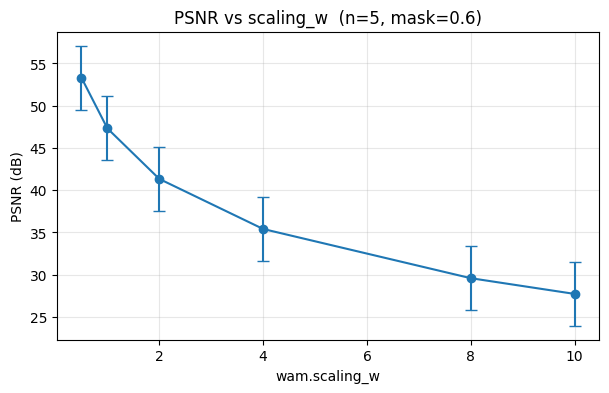

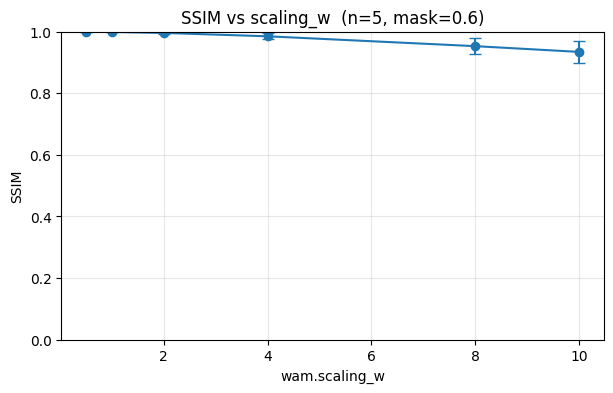

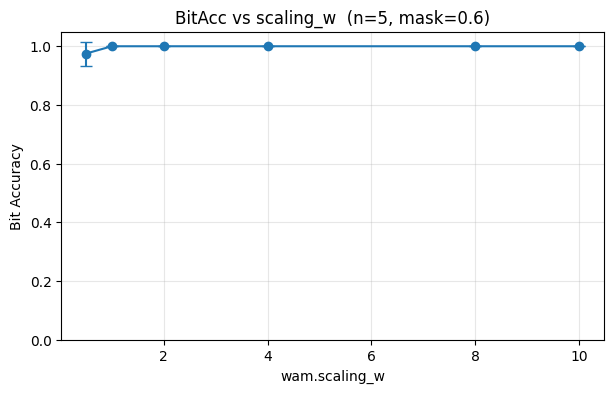

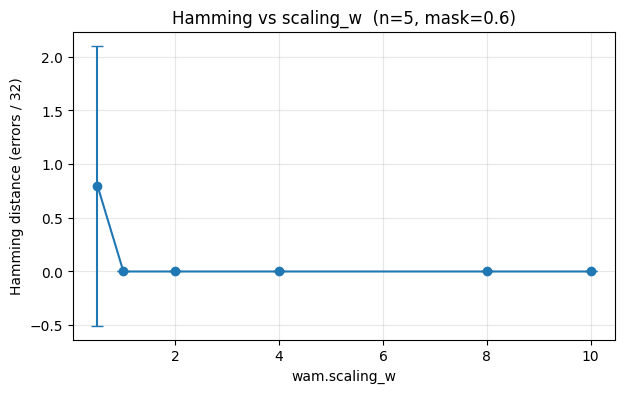

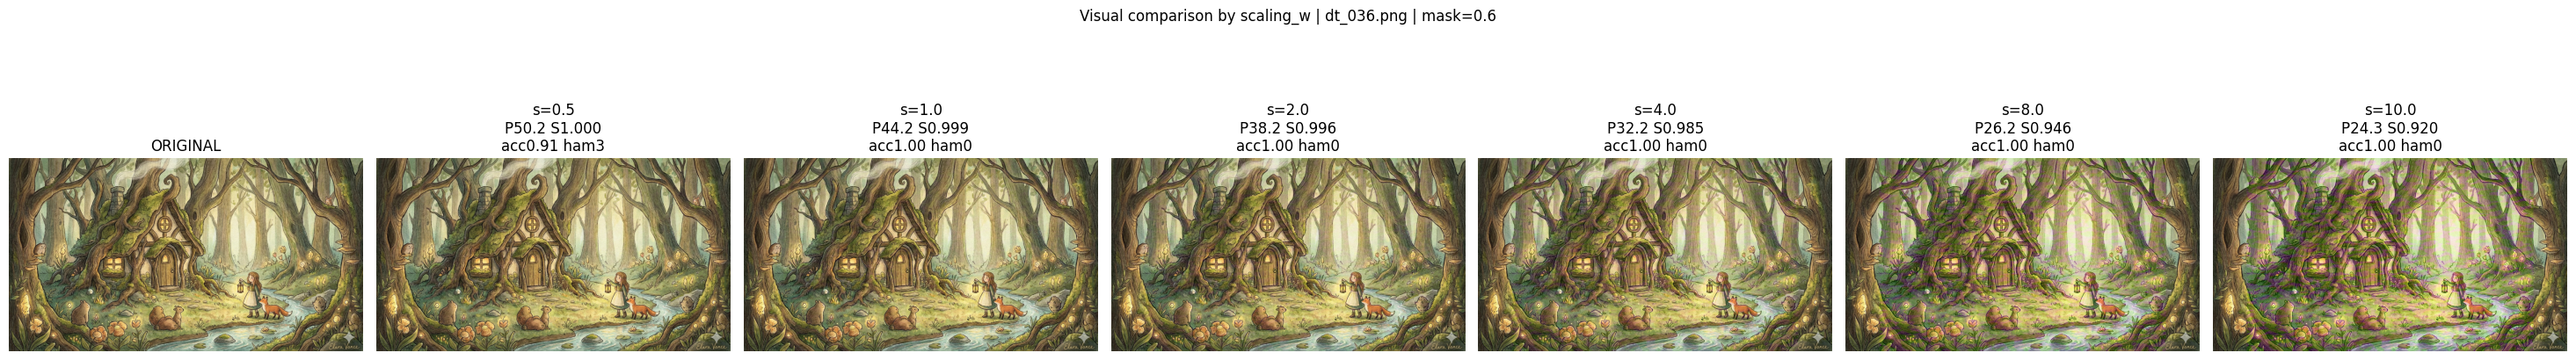

In [10]:

# (추가) 강도(scaling_w)별 시각 비교 + 정량 지표 그래프
import pandas as pd

# 실험 설정
scaling_list = [0.5, 1.0, 2.0, 4.0, 8.0, 10.0]   # 강도 스윕
proportion_masked_eval = proportion_masked        # 위에서 쓰던 비율 그대로 사용
num_eval_imgs = len(picked)                       # 현재는 랜덤 5장

# 공정 비교를 위해: 이미지별로 "고정 메시지 + 고정 마스크"를 한 번 만들어서 모든 scaling에서 재사용
fixed_msgs = {}
fixed_masks = {}

for path in picked:
    img = Image.open(path).convert("RGB")
    img_pt = default_transform(img).unsqueeze(0).to(device)
    fixed_msgs[path.name] = torch.randint(0, 2, (1, 32)).float().to(device)
    fixed_masks[path.name] = create_random_mask(img_pt, num_masks=1, mask_percentage=proportion_masked_eval).to(device)

rows = []

@torch.no_grad()
def run_one(img_pt, wm_msg, mask, scaling_w: float):
    # scaling 세팅
    wam.scaling_w = float(scaling_w)

    # embed
    outputs = wam.embed(img_pt, wm_msg)
    imgs_w = outputs["imgs_w"]
    img_w = imgs_w * mask + img_pt * (1 - mask)

    # detect & decode
    preds = wam.detect(img_w)["preds"]              # [1,33,256,256]
    mask_preds = torch.sigmoid(preds[:, 0, :, :])   # [1,256,256]
    bit_preds  = preds[:, 1:, :, :]                 # [1,32,256,256]
    pred_message = msg_predict_inference(bit_preds, mask_preds).cpu().float()[0]  # [32]
    gt_message   = wm_msg.detach().cpu().float()[0]
    bit_acc = float((pred_message == gt_message).float().mean().item())
    hamming = int(torch.sum(pred_message != gt_message).item())

    # 품질지표: [0,1]에서 계산
    orig_01 = tensor_to_np01(unnormalize_img(img_pt))
    wm_01   = tensor_to_np01(unnormalize_img(img_w))
    psnr, ssim = calc_psnr_ssim(orig_01, wm_01)

    return orig_01, wm_01, psnr, ssim, bit_acc, hamming

# 1) scaling별 정량지표 수집
for path in picked:
    img = Image.open(path).convert("RGB")
    img_pt = default_transform(img).unsqueeze(0).to(device)

    wm_msg = fixed_msgs[path.name]
    mask   = fixed_masks[path.name]

    for s in scaling_list:
        _, _, psnr, ssim, bit_acc, hamming = run_one(img_pt, wm_msg, mask, s)
        rows.append({
            "file": path.name,
            "scaling_w": float(s),
            "psnr": psnr,
            "ssim": ssim,
            "bit_acc": bit_acc,
            "hamming": hamming
        })

df = pd.DataFrame(rows)
display(df.head())

# 2) scaling별 평균/표준편차 그래프
agg = df.groupby("scaling_w").agg(
    psnr_mean=("psnr","mean"), psnr_std=("psnr","std"),
    ssim_mean=("ssim","mean"), ssim_std=("ssim","std"),
    bitacc_mean=("bit_acc","mean"), bitacc_std=("bit_acc","std"),
    ham_mean=("hamming","mean"), ham_std=("hamming","std")
).reset_index()

display(agg)

# PSNR
plt.figure(figsize=(7,4))
plt.errorbar(agg["scaling_w"], agg["psnr_mean"], yerr=agg["psnr_std"], marker="o", capsize=4)
plt.xlabel("wam.scaling_w")
plt.ylabel("PSNR (dB)")
plt.title(f"PSNR vs scaling_w  (n={num_eval_imgs}, mask={proportion_masked_eval})")
plt.grid(True, alpha=0.3)
plt.show()

# SSIM
plt.figure(figsize=(7,4))
plt.errorbar(agg["scaling_w"], agg["ssim_mean"], yerr=agg["ssim_std"], marker="o", capsize=4)
plt.xlabel("wam.scaling_w")
plt.ylabel("SSIM")
plt.title(f"SSIM vs scaling_w  (n={num_eval_imgs}, mask={proportion_masked_eval})")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.show()

# Bit accuracy
plt.figure(figsize=(7,4))
plt.errorbar(agg["scaling_w"], agg["bitacc_mean"], yerr=agg["bitacc_std"], marker="o", capsize=4)
plt.xlabel("wam.scaling_w")
plt.ylabel("Bit Accuracy")
plt.title(f"BitAcc vs scaling_w  (n={num_eval_imgs}, mask={proportion_masked_eval})")
plt.ylim(0.0, 1.05)
plt.grid(True, alpha=0.3)
plt.show()

# Hamming distance
plt.figure(figsize=(7,4))
plt.errorbar(agg["scaling_w"], agg["ham_mean"], yerr=agg["ham_std"], marker="o", capsize=4)
plt.xlabel("wam.scaling_w")
plt.ylabel("Hamming distance (errors / 32)")
plt.title(f"Hamming vs scaling_w  (n={num_eval_imgs}, mask={proportion_masked_eval})")
plt.grid(True, alpha=0.3)
plt.show()

# 3) 강도별 시각 비교 (대표 1장)
# picked 중 첫 번째 이미지를 대표로 사용 (원하면 인덱스 바꿔도 됨)
rep_path = picked[0]
rep_img = Image.open(rep_path).convert("RGB")
rep_pt  = default_transform(rep_img).unsqueeze(0).to(device)
rep_msg = fixed_msgs[rep_path.name]
rep_mask = fixed_masks[rep_path.name]

# 원본
orig_01 = tensor_to_np01(unnormalize_img(rep_pt))

# scaling별 워터마크 이미지 생성
wm_imgs = []
metrics = []
for s in scaling_list:
    _, wm_01, psnr, ssim, bit_acc, hamming = run_one(rep_pt, rep_msg, rep_mask, s)
    wm_imgs.append(wm_01)
    metrics.append((psnr, ssim, bit_acc, hamming))

# Grid 출력: ORIGINAL + 각 scaling 결과
cols = 1 + len(scaling_list)
plt.figure(figsize=(4.2*cols, 4.8))
ax = plt.subplot(1, cols, 1)
ax.imshow(orig_01); ax.set_title("ORIGINAL"); ax.axis("off")

for i, s in enumerate(scaling_list):
    psnr, ssim, bit_acc, hamming = metrics[i]
    ax = plt.subplot(1, cols, 2+i)
    ax.imshow(wm_imgs[i])
    ax.set_title(f"s={s}\nP{psnr:.1f} S{ssim:.3f}\nacc{bit_acc:.2f} ham{hamming}")
    ax.axis("off")

plt.suptitle(f"Visual comparison by scaling_w | {rep_path.name} | mask={proportion_masked_eval}", y=1.05)
plt.tight_layout()
plt.show()
